<a href="https://colab.research.google.com/github/chhaya-000/chhayaproject2/blob/main/project2_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ---------- Step 1: Mount Drive, locate files, and load datasets ----------
# (Run this cell in Colab)

# Optional: install pmdarima if you'll later want auto_arima (not required now)
# !pip install -q pmdarima

from google.colab import drive
import os, glob
import pandas as pd
import numpy as np

# 1) Mount Google Drive
drive.mount('/content/drive')

# 2) Set base folder (update if different)
base_dir = '/content/drive/MyDrive/gridloss'
print('Base folder:', base_dir)
print('Exists?:', os.path.exists(base_dir))
print('\nFiles in folder:')
for f in sorted(os.listdir(base_dir)):
    print(' -', f)

# 3) Find CSV files automatically
csvs = glob.glob(os.path.join(base_dir, '*.csv'))
print('\nCSV files found:')
for i,p in enumerate(csvs):
    print(i, '-', os.path.basename(p))

# 4) Heuristic: pick train/test/backfilled by expected names if present,
# otherwise use the first three csvs found.
def pick_path(name, fallback_index):
    p = os.path.join(base_dir, name)
    return p if os.path.exists(p) else (csvs[fallback_index] if len(csvs) > fallback_index else None)

train_path = pick_path('train.csv', 0)
test_path = pick_path('test.csv', 1)
test_bf_path = pick_path('test_backfilled_missing_features.csv', 2)

print('\nUsing paths:')
print(' train_path =', train_path)
print(' test_path  =', test_path)
print(' test_bf    =', test_bf_path)

# 5) Load (don’t force parsing date yet; we'll inspect columns first)
df_train = pd.read_csv(train_path, low_memory=False) if train_path else None
df_test = pd.read_csv(test_path, low_memory=False) if test_path else None
df_test_bf = pd.read_csv(test_bf_path, low_memory=False) if test_bf_path else None

# 6) Quick inspection function
def quick_inspect(name, df, nrows=5):
    print('\n' + '='*40)
    print(f'INSPECT: {name}')
    if df is None:
        print('  -> NOT FOUND')
        return
    print(' shape:', df.shape)
    print('\n columns:')
    print(list(df.columns))
    print('\n dtypes:')
    print(df.dtypes.value_counts())
    print('\n head:')
    display(df.head(nrows))
    print('\n info():')
    display(df.info())
    print('\n missing per column (top 20):')
    m = df.isnull().sum().sort_values(ascending=False)
    display(m.head(20))
    if 'incorrect_data' in df.columns:
        print('\n incorrect_data value counts:')
        display(df['incorrect_data'].value_counts(dropna=False))
    # show sample of rows where incorrect_data == 1 if present
    if 'incorrect_data' in df.columns and (df['incorrect_data']==1).any():
        print('\n Sample rows where incorrect_data == 1:')
        display(df[df['incorrect_data']==1].head(5))

# Run inspections
quick_inspect('TRAIN', df_train)
quick_inspect('TEST', df_test)
quick_inspect('TEST_BACKFILLED', df_test_bf)

# 7) Print a few summary stats about potential target columns (if present)
for col in ['grid_loss', 'grid_load', 'temperature']:
    for name, df in [('TRAIN', df_train), ('TEST', df_test), ('TEST_BF', df_test_bf)]:
        if df is None:
            continue
        if col in df.columns:
            print(f'{name} - {col}: min={df[col].min():.4g}, max={df[col].max():.4g}, mean={df[col].mean():.4g}, n_null={df[col].isnull().sum()}')

print('\n-- DONE step 1 --\n')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base folder: /content/drive/MyDrive/gridloss
Exists?: True

Files in folder:
 - test.csv
 - test_backfilled_missing_data.csv
 - train.csv

CSV files found:
0 - test_backfilled_missing_data.csv
1 - train.csv
2 - test.csv

Using paths:
 train_path = /content/drive/MyDrive/gridloss/train.csv
 test_path  = /content/drive/MyDrive/gridloss/test.csv
 test_bf    = /content/drive/MyDrive/gridloss/test.csv

INSPECT: TRAIN
 shape: (17520, 39)

 columns:
['Unnamed: 0', 'demand', 'grid1-load', 'grid1-loss', 'grid1-loss-prophet-daily', 'grid1-loss-prophet-pred', 'grid1-loss-prophet-trend', 'grid1-loss-prophet-weekly', 'grid1-loss-prophet-yearly', 'grid1-temp', 'grid2-load', 'grid2-loss', 'grid2-loss-prophet-daily', 'grid2-loss-prophet-pred', 'grid2-loss-prophet-trend', 'grid2-loss-prophet-weekly', 'grid2-loss-prophet-yearly', 'grid2_1-temp', 'grid2_2-temp', 'grid3-load', '

,Unnamed: 0,demand,grid1-load,grid1-loss,grid1-loss-prophet-daily,grid1-loss-prophet-pred,grid1-loss-prophet-trend,grid1-loss-prophet-weekly,grid1-loss-prophet-yearly,grid1-temp,...,month_x,month_y,week_x,week_y,weekday_x,weekday_y,holiday,hour_x,hour_y,has incorrect data
0,2017-12-01 00:00:00,351.225366,449.532,18.766,NaN,NaN,NaN,NaN,NaN,267.85,...,0.866025,-0.5,0.822984,-0.568065,-0.900969,-0.433884,0,1.000000,0.000000,False
1,2017-12-01 01:00:00,344.420458,439.036,18.020,NaN,NaN,NaN,NaN,NaN,267.55,...,0.866025,-0.5,0.822984,-0.568065,-0.900969,-0.433884,0,0.965926,0.258819,False
2,2017-12-01 02:00:00,342.413214,442.237,18.246,NaN,NaN,NaN,NaN,NaN,267.25,...,0.866025,-0.5,0.822984,-0.568065,-0.900969,-0.433884,0,0.866025,0.500000,False
3,2017-12-01 03:00:00,345.427071,447.836,18.645,NaN,NaN,NaN,NaN,NaN,266.95,...,0.866025,-0.5,0.822984,-0.568065,-0.900969,-0.433884,0,0.707107,0.707107,False
4,2017-12-01 04:00:00,357.561257,463.995,19.823,NaN,NaN,NaN,NaN,NaN,267.05,...,0.866025,-0.5,0.822984,-0.568065,-0.900969,-0.433884,0,0.500000,0.866025,False



 info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 17520 non-null  object 
 1   demand                     17518 non-null  float64
 2   grid1-load                 17520 non-null  float64
 3   grid1-loss                 17519 non-null  float64
 4   grid1-loss-prophet-daily   16775 non-null  float64
 5   grid1-loss-prophet-pred    16775 non-null  float64
 6   grid1-loss-prophet-trend   16775 non-null  float64
 7   grid1-loss-prophet-weekly  16775 non-null  float64
 8   grid1-loss-prophet-yearly  16775 non-null  float64
 9   grid1-temp                 17518 non-null  float64
 10  grid2-load                 17520 non-null  float64
 11  grid2-loss                 17519 non-null  float64
 12  grid2-loss-prophet-daily   16775 non-null  float64
 13  grid2-loss-prophet-pred    16775 non

None


 missing per column (top 20):


,0
grid3-loss-prophet-weekly,9504
grid3-loss-prophet-daily,9504
grid3-loss-prophet-yearly,9504
grid3-loss-prophet-trend,9504
grid3-loss-prophet-pred,9504
grid3-loss,7174
grid3-load,6622
grid2-loss-prophet-yearly,745
grid2-loss-prophet-weekly,745
grid2-loss-prophet-trend,745



INSPECT: TEST
 shape: (4369, 39)

 columns:
['Unnamed: 0', 'demand', 'grid1-load', 'grid1-loss', 'grid1-loss-prophet-daily', 'grid1-loss-prophet-pred', 'grid1-loss-prophet-trend', 'grid1-loss-prophet-weekly', 'grid1-loss-prophet-yearly', 'grid1-temp', 'grid2-load', 'grid2-loss', 'grid2-loss-prophet-daily', 'grid2-loss-prophet-pred', 'grid2-loss-prophet-trend', 'grid2-loss-prophet-weekly', 'grid2-loss-prophet-yearly', 'grid2_1-temp', 'grid2_2-temp', 'grid3-load', 'grid3-loss', 'grid3-loss-prophet-daily', 'grid3-loss-prophet-pred', 'grid3-loss-prophet-trend', 'grid3-loss-prophet-weekly', 'grid3-loss-prophet-yearly', 'grid3-temp', 'season_x', 'season_y', 'month_x', 'month_y', 'week_x', 'week_y', 'weekday_x', 'weekday_y', 'holiday', 'hour_x', 'hour_y', 'has incorrect data']

 dtypes:
float64    36
object      1
int64       1
bool        1
Name: count, dtype: int64

 head:


,Unnamed: 0,demand,grid1-load,grid1-loss,grid1-loss-prophet-daily,grid1-loss-prophet-pred,grid1-loss-prophet-trend,grid1-loss-prophet-weekly,grid1-loss-prophet-yearly,grid1-temp,...,month_x,month_y,week_x,week_y,weekday_x,weekday_y,holiday,hour_x,hour_y,has incorrect data
0,2019-12-01 00:00:00,314.396236,407.676,21.5521,-3.93876,25.6415,23.9576,-2.50138,8.12396,272.85,...,0.866025,-0.5,0.822984,-0.568065,0.62349,-0.781831,0,1.000000,0.000000,False
1,2019-12-01 01:00:00,305.691739,397.966,20.7119,-4.41943,25.1920,23.9586,-2.48713,8.13994,273.05,...,0.866025,-0.5,0.822984,-0.568065,0.62349,-0.781831,0,0.965926,0.258819,False
2,2019-12-01 02:00:00,300.431535,392.904,20.2734,-4.49229,25.1594,23.9595,-2.46375,8.15594,273.15,...,0.866025,-0.5,0.822984,-0.568065,0.62349,-0.781831,0,0.866025,0.500000,False
3,2019-12-01 03:00:00,297.064807,392.726,20.2537,-3.91784,25.7832,23.9604,-2.43132,8.17194,273.25,...,0.866025,-0.5,0.822984,-0.568065,0.62349,-0.781831,0,0.707107,0.707107,False
4,2019-12-01 04:00:00,288.463665,394.478,20.4055,-2.60199,27.1573,23.9614,-2.38999,8.18795,273.35,...,0.866025,-0.5,0.822984,-0.568065,0.62349,-0.781831,0,0.500000,0.866025,False



 info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369 entries, 0 to 4368
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 4369 non-null   object 
 1   demand                     4345 non-null   float64
 2   grid1-load                 4345 non-null   float64
 3   grid1-loss                 4335 non-null   float64
 4   grid1-loss-prophet-daily   4345 non-null   float64
 5   grid1-loss-prophet-pred    4345 non-null   float64
 6   grid1-loss-prophet-trend   4345 non-null   float64
 7   grid1-loss-prophet-weekly  4345 non-null   float64
 8   grid1-loss-prophet-yearly  4345 non-null   float64
 9   grid1-temp                 4362 non-null   float64
 10  grid2-load                 4345 non-null   float64
 11  grid2-loss                 4309 non-null   float64
 12  grid2-loss-prophet-daily   4345 non-null   float64
 13  grid2-loss-prophet-pred    4345 non-nu

None


 missing per column (top 20):


,0
grid3-loss,92
grid3-load,73
grid2-loss,60
grid1-loss,34
grid3-loss-prophet-pred,25
grid3-loss-prophet-yearly,25
grid3-loss-prophet-daily,25
grid3-loss-prophet-weekly,25
grid3-loss-prophet-trend,25
grid2-loss-prophet-yearly,24



INSPECT: TEST_BACKFILLED
 shape: (4369, 39)

 columns:
['Unnamed: 0', 'demand', 'grid1-load', 'grid1-loss', 'grid1-loss-prophet-daily', 'grid1-loss-prophet-pred', 'grid1-loss-prophet-trend', 'grid1-loss-prophet-weekly', 'grid1-loss-prophet-yearly', 'grid1-temp', 'grid2-load', 'grid2-loss', 'grid2-loss-prophet-daily', 'grid2-loss-prophet-pred', 'grid2-loss-prophet-trend', 'grid2-loss-prophet-weekly', 'grid2-loss-prophet-yearly', 'grid2_1-temp', 'grid2_2-temp', 'grid3-load', 'grid3-loss', 'grid3-loss-prophet-daily', 'grid3-loss-prophet-pred', 'grid3-loss-prophet-trend', 'grid3-loss-prophet-weekly', 'grid3-loss-prophet-yearly', 'grid3-temp', 'season_x', 'season_y', 'month_x', 'month_y', 'week_x', 'week_y', 'weekday_x', 'weekday_y', 'holiday', 'hour_x', 'hour_y', 'has incorrect data']

 dtypes:
float64    36
object      1
int64       1
bool        1
Name: count, dtype: int64

 head:


,Unnamed: 0,demand,grid1-load,grid1-loss,grid1-loss-prophet-daily,grid1-loss-prophet-pred,grid1-loss-prophet-trend,grid1-loss-prophet-weekly,grid1-loss-prophet-yearly,grid1-temp,...,month_x,month_y,week_x,week_y,weekday_x,weekday_y,holiday,hour_x,hour_y,has incorrect data
0,2019-12-01 00:00:00,314.396236,407.676,21.5521,-3.93876,25.6415,23.9576,-2.50138,8.12396,272.85,...,0.866025,-0.5,0.822984,-0.568065,0.62349,-0.781831,0,1.000000,0.000000,False
1,2019-12-01 01:00:00,305.691739,397.966,20.7119,-4.41943,25.1920,23.9586,-2.48713,8.13994,273.05,...,0.866025,-0.5,0.822984,-0.568065,0.62349,-0.781831,0,0.965926,0.258819,False
2,2019-12-01 02:00:00,300.431535,392.904,20.2734,-4.49229,25.1594,23.9595,-2.46375,8.15594,273.15,...,0.866025,-0.5,0.822984,-0.568065,0.62349,-0.781831,0,0.866025,0.500000,False
3,2019-12-01 03:00:00,297.064807,392.726,20.2537,-3.91784,25.7832,23.9604,-2.43132,8.17194,273.25,...,0.866025,-0.5,0.822984,-0.568065,0.62349,-0.781831,0,0.707107,0.707107,False
4,2019-12-01 04:00:00,288.463665,394.478,20.4055,-2.60199,27.1573,23.9614,-2.38999,8.18795,273.35,...,0.866025,-0.5,0.822984,-0.568065,0.62349,-0.781831,0,0.500000,0.866025,False



 info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369 entries, 0 to 4368
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 4369 non-null   object 
 1   demand                     4345 non-null   float64
 2   grid1-load                 4345 non-null   float64
 3   grid1-loss                 4335 non-null   float64
 4   grid1-loss-prophet-daily   4345 non-null   float64
 5   grid1-loss-prophet-pred    4345 non-null   float64
 6   grid1-loss-prophet-trend   4345 non-null   float64
 7   grid1-loss-prophet-weekly  4345 non-null   float64
 8   grid1-loss-prophet-yearly  4345 non-null   float64
 9   grid1-temp                 4362 non-null   float64
 10  grid2-load                 4345 non-null   float64
 11  grid2-loss                 4309 non-null   float64
 12  grid2-loss-prophet-daily   4345 non-null   float64
 13  grid2-loss-prophet-pred    4345 non-nu

None


 missing per column (top 20):


,0
grid3-loss,92
grid3-load,73
grid2-loss,60
grid1-loss,34
grid3-loss-prophet-pred,25
grid3-loss-prophet-yearly,25
grid3-loss-prophet-daily,25
grid3-loss-prophet-weekly,25
grid3-loss-prophet-trend,25
grid2-loss-prophet-yearly,24



-- DONE step 1 --



Loss columns in train: ['grid1-loss', 'grid1-loss-prophet-daily', 'grid1-loss-prophet-pred', 'grid1-loss-prophet-trend', 'grid1-loss-prophet-weekly', 'grid1-loss-prophet-yearly', 'grid2-loss', 'grid2-loss-prophet-daily', 'grid2-loss-prophet-pred', 'grid2-loss-prophet-trend', 'grid2-loss-prophet-weekly', 'grid2-loss-prophet-yearly', 'grid3-loss', 'grid3-loss-prophet-daily', 'grid3-loss-prophet-pred', 'grid3-loss-prophet-trend', 'grid3-loss-prophet-weekly', 'grid3-loss-prophet-yearly']
Target column selected: grid1-loss

Train period: 2017-12-01 00:00:00 to 2019-11-30 23:00:00
Test period : 2019-12-01 00:00:00 to 2020-05-31 00:00:00

Missing values in train: 1
Missing values in test : 34


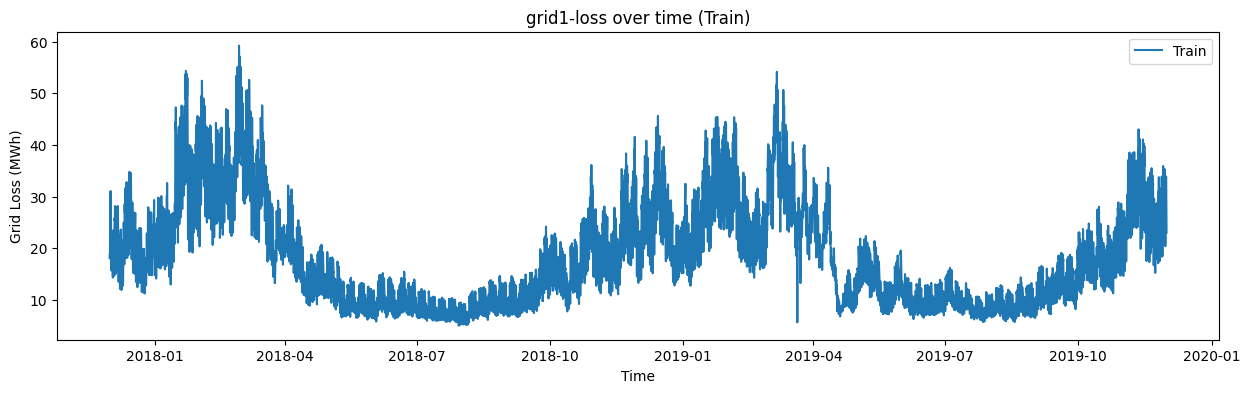


Incorrect data counts (train):
has incorrect data
False    15014
True      2505
Name: count, dtype: int64

Incorrect data counts (test):
has incorrect data
False    4300
True       35
Name: count, dtype: int64

Sample rows where incorrect data == 1:


,demand,grid1-load,grid1-loss,grid1-loss-prophet-daily,grid1-loss-prophet-pred,grid1-loss-prophet-trend,grid1-loss-prophet-weekly,grid1-loss-prophet-yearly,grid1-temp,grid2-load,...,month_x,month_y,week_x,week_y,weekday_x,weekday_y,holiday,hour_x,hour_y,has incorrect data
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-15 00:00:00,334.799060,434.257,26.515,-3.13311,20.5941,10.6564,-0.358372,13.4292,273.95,177.350,...,1.0,0.0,0.970942,0.239316,1.0,0.0,0,1.000000,0.000000,True
2018-01-15 01:00:00,332.993015,417.311,24.639,-3.51517,20.2720,10.6573,-0.273642,13.4035,273.45,174.753,...,1.0,0.0,0.970942,0.239316,1.0,0.0,0,0.965926,0.258819,True
2018-01-15 02:00:00,329.080785,418.295,24.746,-3.58668,20.2581,10.6583,-0.190882,13.3774,272.85,175.261,...,1.0,0.0,0.970942,0.239316,1.0,0.0,0,0.866025,0.500000,True
2018-01-15 03:00:00,330.244546,425.548,25.542,-3.16446,20.7353,10.6592,-0.110372,13.3509,272.35,174.857,...,1.0,0.0,0.970942,0.239316,1.0,0.0,0,0.707107,0.707107,True
2018-01-15 04:00:00,340.685055,439.540,27.115,-2.16862,21.7832,10.6602,-0.032362,13.3241,272.65,181.530,...,1.0,0.0,0.970942,0.239316,1.0,0.0,0,0.500000,0.866025,True


In [ ]:
# ---------- Step 2: Preprocessing ----------
import matplotlib.pyplot as plt

# Convert datetime
for df in [df_train, df_test, df_test_bf]:
    if df is not None:
        # The datetime column is usually named 'Unnamed: 0' or similar
        if 'Unnamed: 0' in df.columns:
            df['datetime'] = pd.to_datetime(df['Unnamed: 0'])
            df.drop(columns=['Unnamed: 0'], inplace=True)
        elif 'time' in df.columns:
            df['datetime'] = pd.to_datetime(df['time'])
            df.drop(columns=['time'], inplace=True)
        df.set_index('datetime', inplace=True)

# Which grid loss columns are available?
loss_cols = [c for c in df_train.columns if 'loss' in c.lower()]
print("Loss columns in train:", loss_cols)

# Let's focus on Grid1 for now
target_col = loss_cols[0] if loss_cols else None
print("Target column selected:", target_col)

# Check train/test periods
print("\nTrain period:", df_train.index.min(), "to", df_train.index.max())
print("Test period :", df_test.index.min(), "to", df_test.index.max())

# Check missing values
if target_col:
    print("\nMissing values in train:", df_train[target_col].isnull().sum())
    print("Missing values in test :", df_test[target_col].isnull().sum())

    # Drop rows with missing target
    df_train = df_train.dropna(subset=[target_col])
    df_test = df_test.dropna(subset=[target_col])

    # Quick plot of training series
    plt.figure(figsize=(15,4))
    plt.plot(df_train.index, df_train[target_col], label='Train')
    plt.title(f"{target_col} over time (Train)")
    plt.xlabel("Time"); plt.ylabel("Grid Loss (MWh)")
    plt.legend(); plt.show()

# Check incorrect data flag
flag_col = None
for c in df_train.columns:
    if 'incorrect' in c.lower():
        flag_col = c
        break

if flag_col:
    print("\nIncorrect data counts (train):")
    print(df_train[flag_col].value_counts())
    print("\nIncorrect data counts (test):")
    print(df_test[flag_col].value_counts())

    print("\nSample rows where incorrect data == 1:")
    display(df_train[df_train[flag_col] == 1].head(5))


In [ ]:
import warnings
import itertools
import statsmodels.api as sm
warnings.filterwarnings("ignore")

# Define ranges
p = range(0, 2)
d = range(0, 2)
q = range(0, 2)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)
m = 24  # daily seasonality

best_aic = np.inf
best_order = None
best_seasonal_order = None

# Simple grid search (can take a few minutes)
for param in itertools.product(p, d, q):
    for seasonal_param in itertools.product(P, D, Q):
        try:
            model = sm.tsa.statespace.SARIMAX(
                df_train['grid1-loss'],
                order=param,
                seasonal_order=seasonal_param + (m,),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue

print("Best SARIMA order:", best_order)
print("Best seasonal_order:", best_seasonal_order + (m,))
print("Best AIC:", best_aic)


Best SARIMA order: (1, 0, 1)
Best seasonal_order: (1, 1, 1, 24)
Best AIC: 37805.40267327939


In [ ]:
# Forward fill or backward fill missing target values
df_train[target_col] = df_train[target_col].fillna(method='ffill')
df_test[target_col] = df_test[target_col].fillna(method='ffill')

# Agar start me NaN hai, use backward fill
df_train[target_col] = df_train[target_col].fillna(method='bfill')
df_test[target_col] = df_test[target_col].fillna(method='bfill')


/tmp/ipython-input-2708782818.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train[target_col] = df_train[target_col].fillna(method='ffill')
/tmp/ipython-input-2708782818.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test[target_col] = df_test[target_col].fillna(method='ffill')
/tmp/ipython-input-2708782818.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train[target_col] = df_train[target_col].fillna(method='bfill')
/tmp/ipython-input-2708782818.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test[target_col] = df_test[target_col].fillna(method='bfill')


In [ ]:
# Check if 'incorrect_data' column exists
if flag_col:
    df_train = df_train[df_train[flag_col] == 0]
    df_test = df_test[df_test[flag_col] == 0]


In [ ]:
df_train = df_train.asfreq('H')
df_test = df_test.asfreq('H')

# Fill any remaining NaNs after resampling
df_train[target_col] = df_train[target_col].fillna(method='ffill')
df_test[target_col] = df_test[target_col].fillna(method='ffill')


/tmp/ipython-input-2142249323.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_train = df_train.asfreq('H')
/tmp/ipython-input-2142249323.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_test = df_test.asfreq('H')
/tmp/ipython-input-2142249323.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train[target_col] = df_train[target_col].fillna(method='ffill')
/tmp/ipython-input-2142249323.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test[target_col] = df_test[target_col].fillna(method='ffill')


/tmp/ipython-input-1234147534.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_train = df_train.asfreq("H")
/tmp/ipython-input-1234147534.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_test = df_test.asfreq("H")
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipython-input-1234147534.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instea

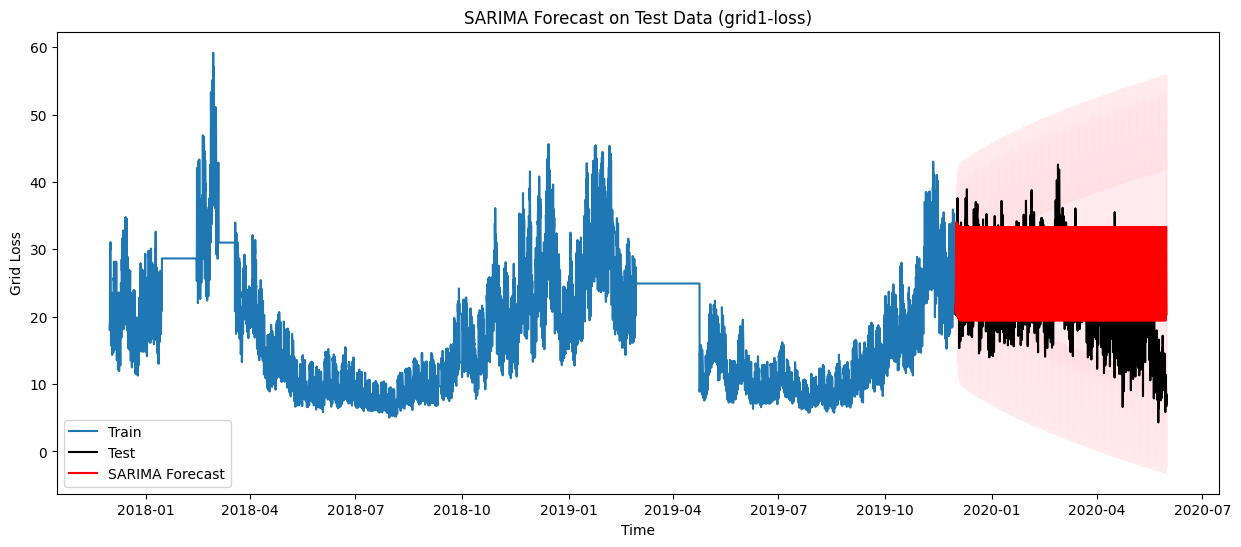

MAE: 5.8816, RMSE: 7.5718


In [ ]:
# Make sure train and test have proper frequency
df_train = df_train.asfreq("H")
df_test = df_test.asfreq("H")

n_test = len(df_test)

# Forecast
sarima_forecast = sarima_results.get_forecast(steps=n_test)
pred_mean = sarima_forecast.predicted_mean
pred_ci = sarima_forecast.conf_int()

# Align forecast index with test
pred_mean.index = df_test.index
pred_ci.index = df_test.index

# Fill NaNs if any
pred_mean = pred_mean.fillna(method="ffill")  # forward fill
df_test_filled = df_test[target_col].fillna(method="ffill")

# Plot forecast vs test
plt.figure(figsize=(15,6))
plt.plot(df_train.index, df_train[target_col], label="Train")
plt.plot(df_test.index, df_test_filled, label="Test", color="black")
plt.plot(pred_mean.index, pred_mean, label="SARIMA Forecast", color="red")
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color="pink", alpha=0.3)
plt.title(f"SARIMA Forecast on Test Data ({target_col})")
plt.xlabel("Time")
plt.ylabel("Grid Loss")
plt.legend()
plt.show()

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(df_test_filled, pred_mean)
rmse = np.sqrt(mean_squared_error(df_test_filled, pred_mean))

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


493/493 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0093 - val_loss: 0.0048
Epoch 2/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 3/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 7.9971e-04 - val_loss: 0.0010
Epoch 4/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 5.5066e-04 - val_loss: 4.8424e-04
Epoch 5/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2.7643e-04 - val_loss: 3.5135e-04
Epoch 6/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 2.3674e-04 - val_loss: 4.3342e-04
Epoch 7/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2.0809e-04 - val_loss: 3.5867e-04
Epoch 8/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 1.8988e-04 - val_loss: 2.8325e-04
Epoch 9/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1.8514e-04 - val_loss: 2.7790e-04
Epoch 10/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.9287e-04 - val_loss: 2.9942e-04
Epoch 11/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 1.7162e-04 - val_l

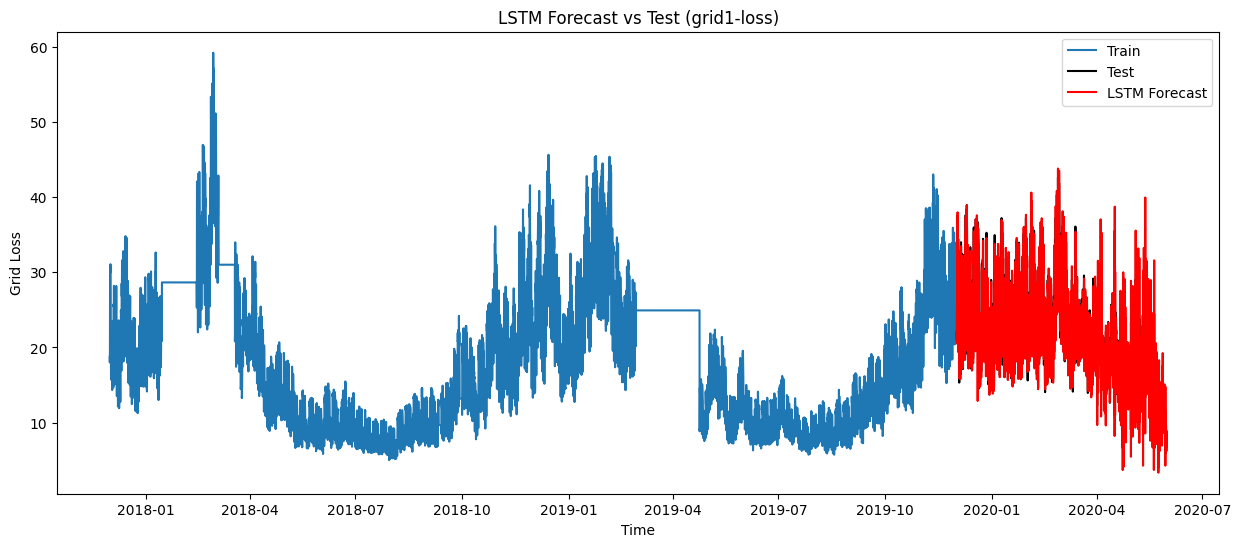

In [ ]:
# ---------- Step 4: Prepare data for LSTM ----------
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Use only target column for univariate LSTM
target = target_col

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(df_train[[target]])
test_scaled = scaler.transform(df_test[[target]])

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # using past 24 hours to predict next hour
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# ---------- Step 5: Build LSTM model ----------
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# ---------- Step 6: Train LSTM ----------
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# ---------- Step 7: Make predictions ----------
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Align y_test with original values
y_test_orig = df_test[target].values[seq_length:]

# ---------- Step 8: Evaluate ----------
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
print(f"LSTM MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# ---------- Step 9: Plot ----------
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(df_train.index, df_train[target], label="Train")
plt.plot(df_test.index[seq_length:], y_test_orig, label="Test", color="black")
plt.plot(df_test.index[seq_length:], y_pred, label="LSTM Forecast", color="red")
plt.title(f"LSTM Forecast vs Test ({target})")
plt.xlabel("Time")
plt.ylabel("Grid Loss")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Align forecast with test set if possible
# Agar test set me sirf n_future points hi available hai
lstm_pred_series = pd.Series(forecast.flatten(), index=forecast_index)

# Fill test NaNs
df_test_filled = df_test[target].fillna(method="ffill")

# Calculate metrics (only for overlapping period)
common_index = df_test_filled.index.intersection(lstm_pred_series.index)
mae_lstm = mean_absolute_error(df_test_filled.loc[common_index], lstm_pred_series.loc[common_index])
rmse_lstm = np.sqrt(mean_squared_error(df_test_filled.loc[common_index], lstm_pred_series.loc[common_index]))

print(f"LSTM Multi-step Forecast - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")


LSTM Multi-step Forecast - MAE: 2.8578, RMSE: 3.3859


/tmp/ipython-input-2540346701.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test_filled = df_test[target].fillna(method="ffill")


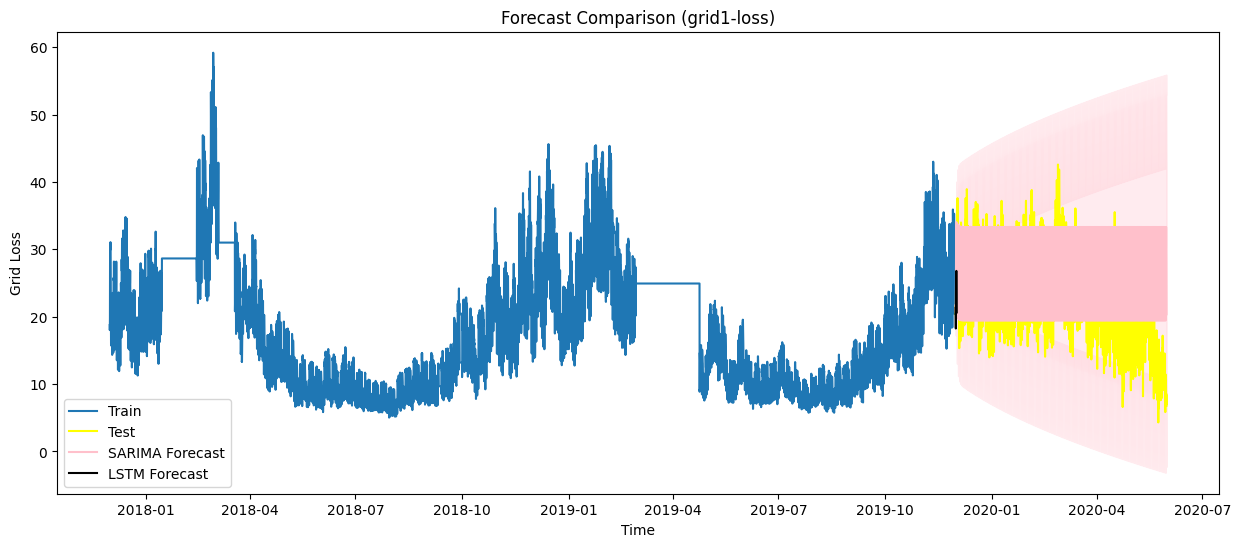

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df_train.index, df_train[target], label="Train")
plt.plot(df_test.index, df_test_filled, label="Test", color="yellow")
plt.plot(pred_mean.index, pred_mean, label="SARIMA Forecast", color="pink")
plt.plot(forecast_index, forecast, label="LSTM Forecast", color="black")
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color="pink", alpha=0.3)
plt.title(f"Forecast Comparison ({target})")
plt.xlabel("Time")
plt.ylabel("Grid Loss")
plt.legend()
plt.show()


In [ ]:
# ---------- Step 10: Multi-step Forecast for full test period ----------
n_test = len(df_test)
forecast_scaled = []

# Start from last seq_length points of training data
last_sequence = train_scaled[-seq_length:]
current_seq = last_sequence.reshape(1, seq_length, 1)  # shape: (1, seq_length, 1)

for _ in range(n_test):
    # Predict next step
    next_pred_scaled = model.predict(current_seq, verbose=0)[0,0]
    forecast_scaled.append(next_pred_scaled)

    # Convert prediction to 3D array and update current_seq
    next_pred_scaled_3d = np.array(next_pred_scaled).reshape(1,1,1)
    current_seq = np.concatenate((current_seq[:,1:,:], next_pred_scaled_3d), axis=1)

# Convert back to original scale
forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1,1))

# Use df_test.index as datetime index for alignment
forecast_index = df_test.index

# Plot forecast vs test
plt.figure(figsize=(15,6))
plt.plot(df_train.index, df_train[target], label="Train")
plt.plot(df_test.index, df_test[target], label="Test", color="black")
plt.plot(forecast_index, forecast, label="LSTM Multi-step Forecast", color="green")
plt.title(f"LSTM Forecast aligned with SARIMA ({target})")
plt.xlabel("Time")
plt.ylabel("Grid Loss")
plt.legend()
plt.show()

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(df_test[target], forecast)
rmse = np.sqrt(mean_squared_error(df_test[target], forecast))
print(f"LSTM MAE: {mae:.4f}, RMSE: {rmse:.4f}")


KeyboardInterrupt: 

In [ ]:
from google.colab import drive
import os, glob
import pandas as pd

drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/gridloss'
csvs = glob.glob(os.path.join(base_dir, '*.csv'))

def pick_path(name, fallback_index):
    p = os.path.join(base_dir, name)
    return p if os.path.exists(p) else (csvs[fallback_index] if len(csvs) > fallback_index else None)

train_path = pick_path('train.csv', 0)
test_path = pick_path('test.csv', 1)

df_train = pd.read_csv(train_path, low_memory=False)
df_test = pd.read_csv(test_path, low_memory=False)

print("Train shape:", df_train.shape)
print("Test shape :", df_test.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shape: (17520, 39)
Test shape : (4369, 39)


Target column: grid1-loss


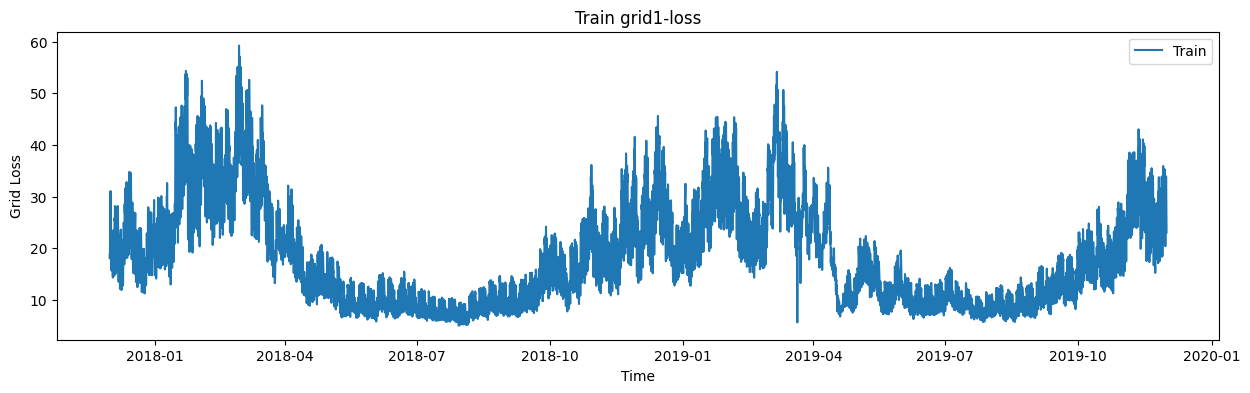

In [ ]:
import matplotlib.pyplot as plt

# Convert datetime and set index
for df in [df_train, df_test]:
    if 'Unnamed: 0' in df.columns:
        df['datetime'] = pd.to_datetime(df['Unnamed: 0'])
        df.drop(columns=['Unnamed: 0'], inplace=True)
    df.set_index('datetime', inplace=True)

# Select target (first column with 'loss')
loss_cols = [c for c in df_train.columns if 'loss' in c.lower()]
target_col = loss_cols[0]
print("Target column:", target_col)

# Drop rows with missing target
df_train = df_train.dropna(subset=[target_col])
df_test = df_test.dropna(subset=[target_col])

# Plot train series
plt.figure(figsize=(15,4))
plt.plot(df_train[target_col], label='Train')
plt.title(f"Train {target_col}")
plt.xlabel("Time"); plt.ylabel("Grid Loss")
plt.legend()
plt.show()


In [ ]:
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")

# SARIMA parameter search
p=d=q=P=D=Q=range(0,2)
m = 24  # daily seasonality
best_aic = np.inf

for param in itertools.product(p,d,q):
    for seasonal_param in itertools.product(P,D,Q):
        try:
            model = sm.tsa.statespace.SARIMAX(
                df_train[target_col],
                order=param,
                seasonal_order=seasonal_param+(m,),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue

print("Best SARIMA order:", best_order)
print("Best seasonal_order:", best_seasonal_order+(m,))

sarima_model = sm.tsa.statespace.SARIMAX(
    df_train[target_col],
    order=best_order,
    seasonal_order=best_seasonal_order+(m,),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit(disp=False)

# Forecast full test period
n_test = len(df_test)
sarima_forecast = sarima_results.get_forecast(steps=n_test)
pred_mean = sarima_forecast.predicted_mean.fillna(method="ffill")
pred_ci = sarima_forecast.conf_int().fillna(method="ffill")


Best SARIMA order: (1, 0, 1)
Best seasonal_order: (1, 1, 1, 24)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train[[target_col]])
test_scaled = scaler.transform(df_test[[target_col]])

seq_length = 24  # past 24 hours to predict next
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, seq_length)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length,1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0188
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0011
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 5.8452e-04
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.6673e-04
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 4.2241e-04
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 3.3816e-04
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 3.7263e-04
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 3.3268e-04
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 3.2631e-04
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 3.0190e-04
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.9733e-04
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 2.8620e-04
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 3.1518e-04
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 2.888

In [ ]:
forecast_scaled = []
last_seq = train_scaled[-seq_length:].reshape(1,seq_length,1)
current_seq = last_seq.copy()

for _ in range(n_test):
    next_pred_scaled = model.predict(current_seq, verbose=0)[0,0]
    forecast_scaled.append(next_pred_scaled)
    next_pred_3d = np.array(next_pred_scaled).reshape(1,1,1)
    current_seq = np.concatenate((current_seq[:,1:,:], next_pred_3d), axis=1)

lstm_forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1,1))


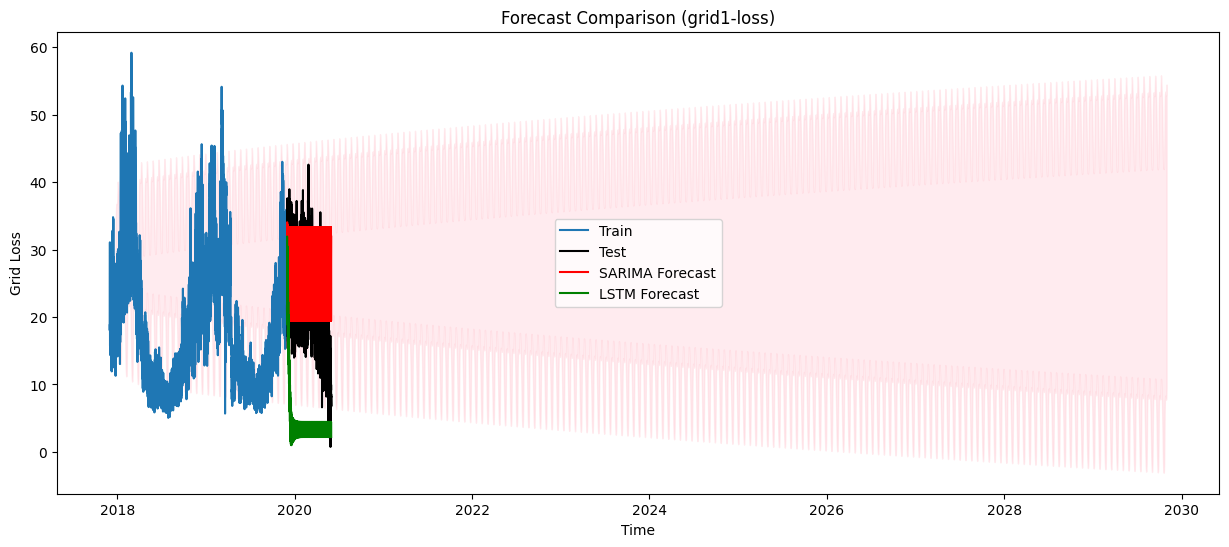

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df_train.index, df_train[target_col], label="Train")
plt.plot(df_test.index, df_test[target_col], label="Test", color="black")
plt.plot(df_test.index, pred_mean, label="SARIMA Forecast", color="red")
plt.plot(df_test.index, lstm_forecast, label="LSTM Forecast", color="green")
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color="pink", alpha=0.3)
plt.title(f"Forecast Comparison ({target_col})")
plt.xlabel("Time"); plt.ylabel("Grid Loss")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_sarima = mean_absolute_error(df_test[target_col], pred_mean)
rmse_sarima = np.sqrt(mean_squared_error(df_test[target_col], pred_mean))

mae_lstm = mean_absolute_error(df_test[target_col], lstm_forecast)
rmse_lstm = np.sqrt(mean_squared_error(df_test[target_col], lstm_forecast))

print(f"SARIMA MAE: {mae_sarima:.4f}, RMSE: {rmse_sarima:.4f}")
print(f"LSTM MAE  : {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")
